# Tutorial 4 - Trace and major elements using the phaseDiagram module

*Simon Matthews (University of Cambridge)*

I should probably merge this with tutorial 3, but it is useful to keep them separate for now.

This tutorial goes through how we can use the predictions from thermocalc and pMELTS for the evolution of residuum mineralogy and magma composition with pyMelt. The path through the P-T space is still calculated by pyMelt. The pyMelt.phaseDiagram package provides algorithms for (calculating and) importing a grid of results, followed by fitting interpolation functions to provide a lookup table.

First, import required packages:

In [1]:
import pyMelt as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This should output '3.dev0', if it doesn't then you need to install the dev version before continuing.

In [2]:
m.__version__

'3.dev0'

## Outline
We are going to perform calculations in stages:
1. Define a multi-lithology mantle
2. Calculate the P-T path the mantle takes during decompression melting, and the melt fractions produced in each lithology along that path.
3. Set up information about the chemical properties of the mantle components that are melting, in particular how their mineralogy changes during melting, and their budget of trace/minor elements.
4. Calculate the composition of the instantaneous melts produced during decompression melting
5. Process the results in light of the geological setting where the melts are being produced.


## 1. Define the multi-lithology mantle

Here we will work with two components, a lherzolite and a pyroxenite. Look back at the other tutorials to see how to add in a harzburgite if you want to do that too!

In [3]:
lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()

Next we will combine these into a mantle with 90% lherzolite:

In [4]:
mantle = m.mantle([lz, px], [0.9, 0.1], ['lz', 'px'])

## 2. Calculate decompression melting

Now we will do decompression melting at a $T_p$ of 1500˚C to make a melting column:

In [5]:
column = mantle.adiabaticMelt(1500.0, dP=-0.004)

/Users/sm905/repos/pyMelt/pyMelt/mantle_class.py:476: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


We can check what this calculation did by making a plot:

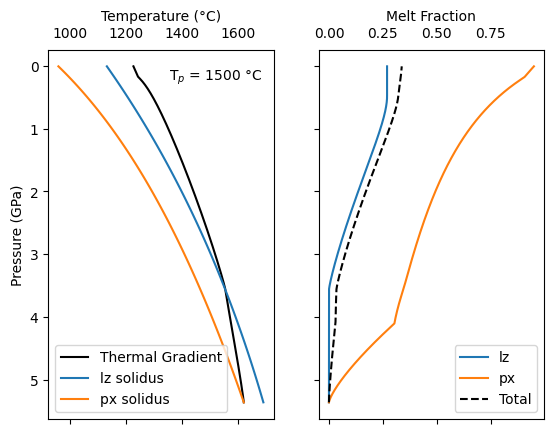

In [6]:
fig, ax = column.plot()

plt.show()

## 3. Set up chemical properties
This step is the most involved as it requires the most additional information and assumptions. To make it really clear and easy to change I am going to define every parameter here. You could also rely on pyMelt defaults or extract some of the built in data, but it might be a bit harder to track what's going on! The existing tutorial 3 draws in some of the built in data, so look there for an example.

### 3.1: Define mineralogy and major elements
The big update with pyMelt v3 is the incorporation of phase diagrams calculated using thermodynamic modelling codes. We will import the KLB1 lherzolite phase diagram calculated by THERMOCALC:

In [7]:
phasediag_klb1 = m.load_phaseDiagram('thermocalc_klb1')

We can see the information stored in here:

In [8]:
phasediag_klb1.variables

Index(['pressure', 'temperature', 'X', 'cpx', 'cpx_Al2O3', 'cpx_CaO',
       'cpx_Cr2O3', 'cpx_FeO', 'cpx_K2O', 'cpx_MgO',
       ...
       'plg_TiO2_wtpt', 'plg_Cr2O3_wtpt', 'plg_Fe2O3_wtpt', 'olv_Mg#',
       'cpx_Mg#', 'opx_Mg#', 'grt_Mg#', 'spn_Mg#', 'liq_Mg#', 'plg_Mg#'],
      dtype='object', length=239)

And we can lookup any of these values by supplying a pressure and melt fraction:

In [9]:
phasediag_klb1('liq_MgO_wtpt', state=pd.Series({'P':2.0, 'F':0.1}))

14.540319136020456

In [10]:
phasediag_klb1('grt_mass', state=pd.Series({'P':4.0, 'F':0.05}))

0.09228332373081183

We can do the same for KG1:

In [11]:
phasediag_kg1 = m.load_phaseDiagram('thermocalc_kg1')

### 3.2: Define source trace/minor element concentrations:

We need to provide the concentrations for the trace elements in each source:

In [12]:
# Workman & Hart (2005) DMM:
lz_tes = {
    "Rb": 0.05,
    "Ba": 0.563,
    "Th": 0.0079,
    "U": 0.0032,
    "Nb": 0.1485,
    "Ta": 0.0096,
    "La": 0.192,
    "Ce": 0.550,
    "Pb": 0.018,
    "Nd": 0.581,
    "Sr": 7.664,
    "Zr": 5.082,
    "Hf": 0.157,
    "Sm": 0.239,
    "Eu": 0.096,
    "Ti": 716.3,
    "Gd": 0.358,
    "Dy": 0.505,
    "Y": 3.328,
    "Er": 0.348,
    "Yb": 0.365,
    "Lu": 0.058,
}

# Stracke et al. (2003) recycled crust:
# These might be too high!
px_tes = {
    "Rb": 0.57,
    "Ba": 6.59,
    "Th": 0.088,
    "U": 0.027,
    "Nb": 1.95,
    "Ta": 0.124,
    "La": 1.68,
    "Ce": 5.89,
    "Pb": 0.09,
    "Nd": 7.45,
    "Sr": 81.0,
    "Zr": 64.0,
    "Hf": 1.78,
    "Sm": 2.69,
    "Eu": 1.04,
    "Ti": 7735.0,
    "Gd": 4.03,
    "Dy": 5.01,
    "Y": 28.5,
    "Er": 3.13,
    "Yb": 2.99,
    "Lu": 0.45,
}

### 3.3 Define partition coefficients:
We need to provide a partition coefficient for each mineral. Here we use constant Ds, but pyMelt will let you use variable ones too... see tutorial 3!

In [13]:
# From Gibson & Geist compilation
olv_D = {
    "Rb": 0.0003,
    "Ba": 0.000005,
    "Th": 0.00005,
    "U": 0.00038,
    "Nb": 0.0005,
    "Ta": 0.0005,
    "La": 0.0005,
    "Ce": 0.0005,
    "Pb": 0.003,
    "Pr": 0.0008,
    "Nd": 0.00042,
    "Sr": 0.00004,
    "Zr": 0.0033,
    "Hf": 0.0022,
    "Sm": 0.0011,
    "Eu": 0.0016,
    "Ti": 0.015,
    "Gd": 0.0011,
    "Tb": 0.0015,
    "Dy": 0.0027,
    "Ho": 0.0016,
    "Y": 0.0099,
    "Er": 0.013,
    "Yb": 0.020,
    "Lu": 0.020,
}

# From Gibson & Geist compilation
opx_D = {
    "Rb": 0.0002,
    "Ba": 0.000006,
    "Th": 0.002,
    "U": 0.002,
    "Nb": 0.004,
    "Ta": 0.004,
    "La": 0.0031,
    "Ce": 0.0040,
    "Pb": 0.009,
    "Pr": 0.0048,
    "Nd": 0.01200,
    "Sr": 0.0007,
    "Zr": 0.013,
    "Hf": 0.03,
    "Sm": 0.0200,
    "Eu": 0.0130,
    "Ti": 0.086,
    "Gd": 0.0130,
    "Tb": 0.0190,
    "Dy": 0.0110,
    "Ho": 0.0065,
    "Y": 0.052,
    "Er": 0.045,
    "Yb": 0.080,
    "Lu": 0.120,
}

# From Gibson & Geist compilation
cpx_D = {
    "Rb": 0.0004,
    "Ba": 0.0004,
    "Th": 0.0059,
    "U": 0.0094,
    "Nb": 0.015,
    "Ta": 0.015,
    "La": 0.0490,
    "Ce": 0.0800,
    "Pb": 0.012,
    "Pr": 0.126,
    "Nd": 0.17800,
    "Sr": 0.091,
    "Zr": 0.119,
    "Hf": 0.284,
    "Sm": 0.2930,
    "Eu": 0.3350,
    "Ti": 0.350,
    "Gd": 0.3500,
    "Tb": 0.4030,
    "Dy": 0.4000,
    "Ho": 0.4270,
    "Y": 0.426,
    "Er": 0.420,
    "Yb": 0.400,
    "Lu": 0.376,
}

# From Gibson & Geist compilation
grt_D = {
    "Rb": 0.0002,
    "Ba": 0.00007,
    "Th": 0.009,
    "U": 0.028,
    "Nb": 0.015,
    "Ta": 0.015,
    "La": 0.0010,
    "Ce": 0.0050,
    "Pb": 0.005,
    "Pr": 0.014,
    "Nd": 0.05200,
    "Sr": 0.0007,
    "Zr": 0.270,
    "Hf": 0.400,
    "Sm": 0.2500,
    "Eu": 0.4960,
    "Ti": 0.600,
    "Gd": 0.84800,
    "Tb": 1.4770,
    "Dy": 2.2000,
    "Ho": 3.3150,
    "Y": 3.100,
    "Er": 4.400,
    "Yb": 6.600,
    "Lu": 7.100,
}

# alphaMELTS defaults
spn_D = {
    "Rb": 0.0001,
    "Ba": 0.0001,
    "Th": 0.0,
    "U": 0.0,
    "Nb": 0.0,
    "Ta": 0.0,
    "La": 0.0100,
    "Ce": 0.0100,
    "Pb": 0.0,
    "Pr": 0.01,
    "Nd": 0.0100,
    "Sr": 0.0,
    "Zr": 0.0,
    "Hf": 0.0,
    "Sm": 0.0100,
    "Eu": 0.0100,
    "Ti": 0.15,
    "Gd": 0.0100,
    "Tb": 0.0100,
    "Dy": 0.0100,
    "Ho": 0.0100,
    "Y": 0.01,
    "Er": 0.0100,
    "Yb": 0.0100,
    "Lu": 0.0100,
}

# From Gibson & Geist compilation
plg_D = {
    "Rb": 0.03,
    "Ba": 0.33,
    "Th": 0.05,
    "U": 0.11,
    "Nb": 0.01,
    "Ta": 0.0,
    "La": 0.2700,
    "Ce": 0.200,
    "Pb": 0.36,
    "Pr": 0.17,
    "Nd": 0.1400,
    "Sr": 2.0,
    "Zr": 0.01,
    "Hf": 0.01,
    "Sm": 0.1100,
    "Eu": 0.7300,
    "Ti": 0.04,
    "Gd": 0.0660,
    "Tb": 0.0600,
    "Dy": 0.0550,
    "Ho": 0.0480,
    "Y": 0.03,
    "Er": 0.0100,
    "Yb": 0.031,
    "Lu": 0.0250,
}

## 4. Calculate instantaneous melt concentrations:
Feed all of this info into pyMelt:

In [14]:
column.calculateChemistry(elements={'lz': lz_tes,
                                    'px': px_tes},
                          method='phase_diagram_trace',
                          phaseDiagram={'lz': phasediag_klb1,
                                        'px': phasediag_kg1},
                          olv_D = olv_D,
                          cpx_D = cpx_D,
                          opx_D = opx_D,
                          grt_D = grt_D,
                          spn_D = spn_D,
                          plg_D = plg_D,
                          # porosity = 0.0
                         )

Repeat for the major elements. This is a bit clunky at the moment, but you can ignore most of the code here beyond the first line.

In [15]:
column.calculateChemistry(elements={'lz': {'MgO': np.nan,
                                           'FeO': np.nan},
                                    'px': {'MgO': np.nan,
                                           'FeO': np.nan},
                                    },
                          method='phase_diagram_major',
                          phaseDiagram={'lz': phasediag_klb1,
                                        'px': phasediag_kg1})

## 5. Create a geoSetting
To turn the melting column results into something applicable to a real world application we need to create a geoSetting. Here I create a spreadingCentre geosetting:

In [16]:
geo = m.geosettings.spreadingCentre(column)

This has calculated the crustal thickness, removed the melts that would be created at shallower levels than this, and then homogenised the melts assuming a triangular melting region. It is also possible to simulate active plume upwelling, see the documentation (or another tutorial) for more information.

## 6. Inspect Results

We can make some plots to visualise the results:

(<Figure size 960x720 with 1 Axes>, <Axes: ylabel='Normalised concentration'>)

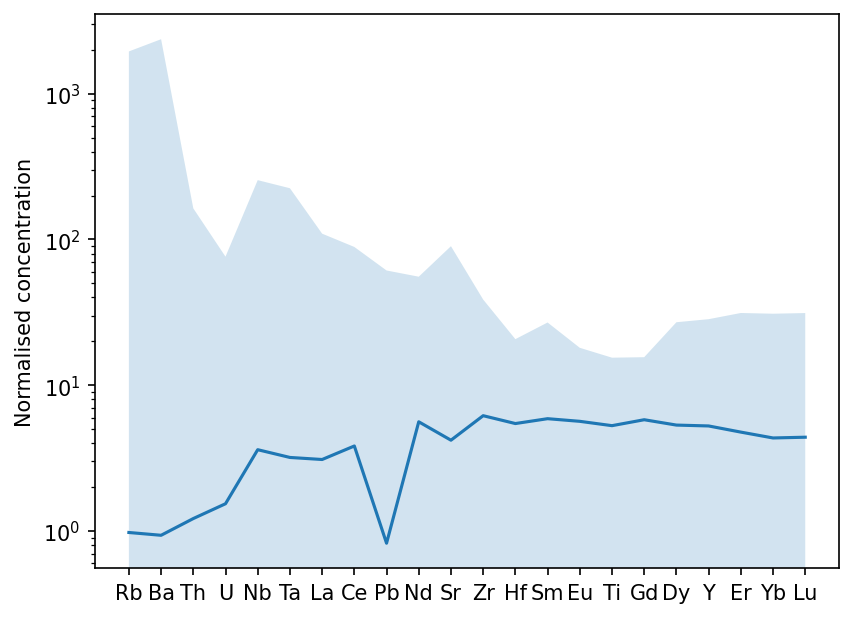

In [19]:
f, a = geo.plotSpider(plot_instantaneous=True)

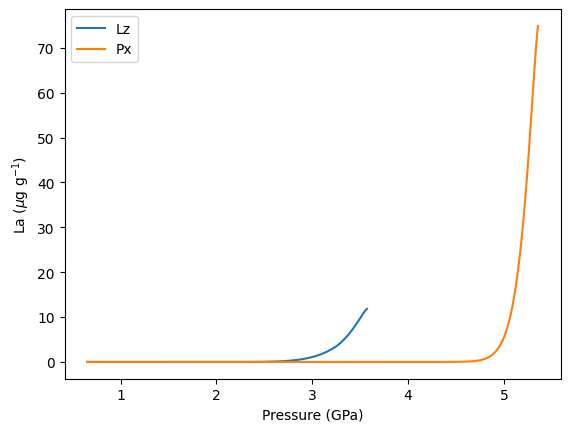

In [26]:
f, a = plt.subplots()

a.plot(geo.P, geo.lithologies['lz'].La, label='Lz')
a.plot(geo.P, geo.lithologies['px'].La, label='Px')

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('La ($\mu$g g$^{-1}$)')

a.legend()

plt.show()

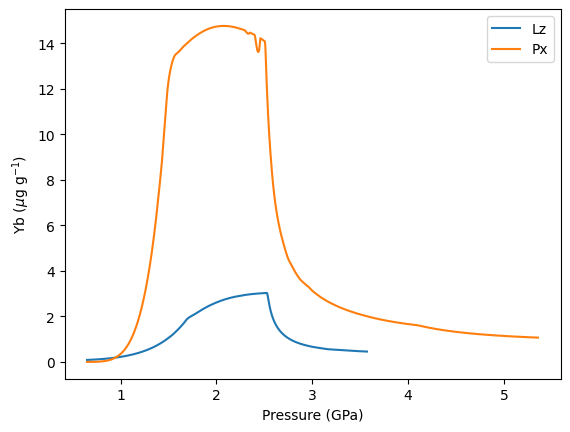

In [27]:
f, a = plt.subplots()

a.plot(geo.P, geo.lithologies['lz'].Yb, label='Lz')
a.plot(geo.P, geo.lithologies['px'].Yb, label='Px')

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('Yb ($\mu$g g$^{-1}$)')

a.legend()

plt.show()

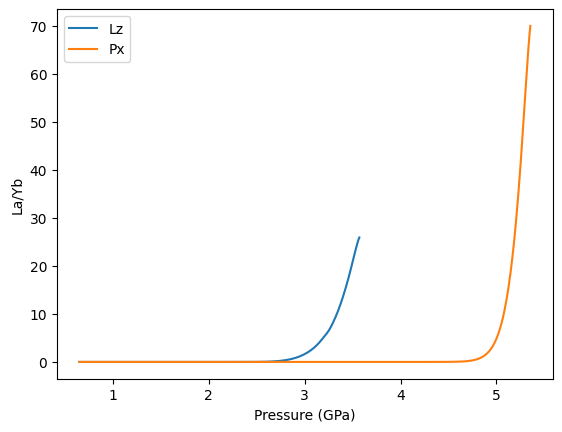

In [28]:
f, a = plt.subplots()

a.plot(geo.P, geo.lithologies['lz'].La / geo.lithologies['lz'].Yb, label='Lz')
a.plot(geo.P, geo.lithologies['px'].La / geo.lithologies['px'].Yb, label='Px')

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('La/Yb')

a.legend()

plt.show()

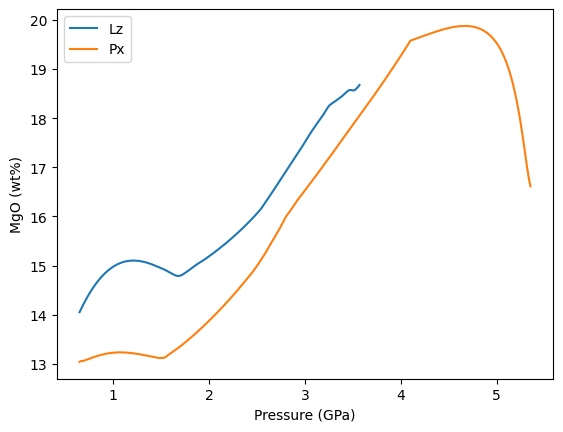

In [30]:
f, a = plt.subplots()

a.plot(geo.P, geo.lithologies['lz'].MgO, label='Lz')
a.plot(geo.P, geo.lithologies['px'].MgO, label='Px')

a.legend()

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('MgO (wt%)')


plt.show()